# Errors in the ice floe tracker segmentation step

In some images, portions of the land mask appear in the segmented ice floe regions. This, of course, should not be happening. Here, we'll walk through each step of the preprocessing routine as implemented in the IFT-Pipeline. To run this, you'll need to add the package Folds (used in watershed), Images and IceFloeTracker.

I've gathered a couple cases for examples.
- Case 45:  clearly separated floes, thin cloud cover. IFT functions essentially as expected, with the algorithm mainly picking out ice floes but over eroding the edges.
- Case 24: gets mixed up with the land mask being labeled as an ice floe.
- Case 122: identifies floes, does not get mixed up with land mask
- Case 283: gets mixed up with the land mask

## 1. Creating landmask

In [1]:
using Pkg
using IceFloeTracker
using Folds
using Images
using Distributed # for parallel processing
addprocs(1) # single worker process for watershed computation
# Pkg.precompile()
imshow(img) = Gray.(img)
cases = ["110-beaufort_sea",
         "119-beaufort_sea",
         "142-beaufort_sea",
         "145-beaufort_sea",
         "324-hudson_bay",
         "340-hudson_bay",
         "385-laptev_sea",
         "447-east_siberian_sea",
         "454-hudson_bay"]
case = cases[1]
data_dir = joinpath("data", case);

  4.707941 seconds (1.89 M allocations: 123.715 MiB, 0.27% gc time, 74.71% compilation time)
Left to right: Original, Binary, Dilated

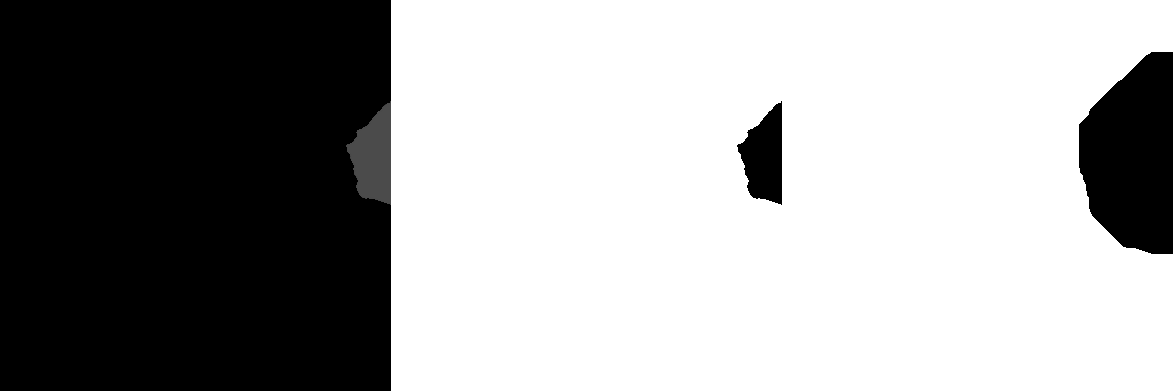

In [6]:
landmask = load(joinpath(data_dir, case*"-100km-landmask.tiff"));
@time landmask_imgs = IceFloeTracker.create_landmask(landmask);
print("Left to right: Original, Binary, Dilated")
Images.mosaicview(landmask, Gray.(landmask_imgs.non_dilated),
    Gray.(landmask_imgs.dilated), nrow=1)

# Load satellite images

In [36]:
Pkg.update("IceFloeTracker")


    Updating registry at `~/.julia/registries/General`
    Updating git-repo `https://github.com/JuliaRegistries/General`
    Updating registry at `~/.julia/registries/HolyLabRegistry`
    Updating git-repo `https://github.com/HolyLab/HolyLabRegistry.git`
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


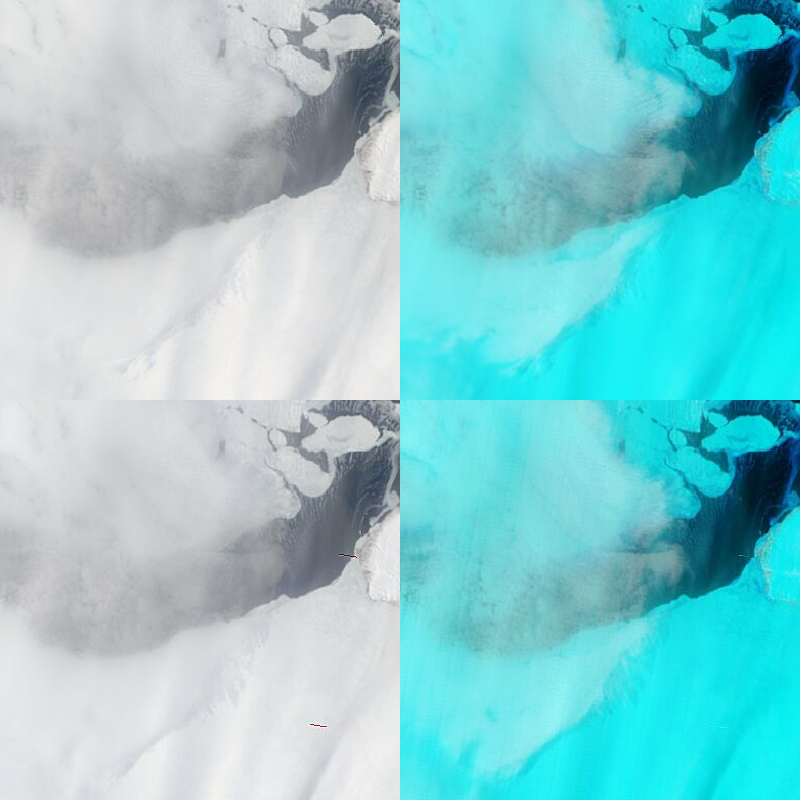

In [23]:
tc_images = [
        IceFloeTracker.float64.(load(joinpath(data_dir, f))) for
        f in readdir(data_dir) if contains(f, string("truecolor"))
    ];
fc_images = [
        float64.(load(joinpath(data_dir, f))) for
        f in readdir(data_dir) if contains(f, string("falsecolor"))
    ];
Images.mosaicview([tc_images; fc_images], nrow=2)

# Cloudmask

In [26]:
falsecolor_image = RGB(fc_images[1][1, :, :)
truecolor_image = tc_images[1]
# Options to set for cloudmask:
# prelim_threshold, band_7_threshold, band_2_threshold, ratio_lower, ratio_upper
cloudmask = IceFloeTracker.create_cloudmask(falsecolor_image)

LoadError: MethodError: [0mCannot `convert` an object of type 
[0m  [92mMatrix{RGBA{Float64}}[39m[0m to an object of type 
[0m  [91mRGB[39m

[0mClosest candidates are:
[0m  convert(::Type{C}, [91m::C[39m) where C<:Colorant
[0m[90m   @[39m [35mColorTypes[39m [90m~/.julia/packages/ColorTypes/vpFgh/src/[39m[90m[4mconversions.jl:72[24m[39m
[0m  convert(::Type{T}, [91m::T[39m) where T
[0m[90m   @[39m [90mBase[39m [90m[4mBase.jl:84[24m[39m
[0m  convert(::Type{C}, [91m::Number[39m) where C<:Colorant
[0m[90m   @[39m [35mColorTypes[39m [90m~/.julia/packages/ColorTypes/vpFgh/src/[39m[90m[4mconversions.jl:74[24m[39m
[0m  ...


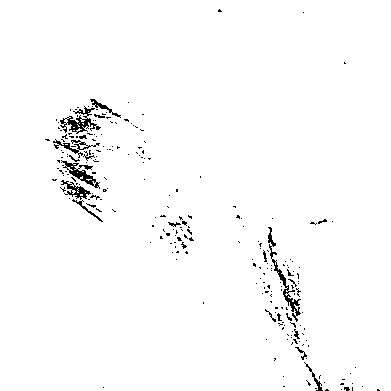

In [9]:
imshow(cloudmask)

## Image sharpening
For case 24, the truecolor image is quite over-sharpened - there is a lot of amplified gain in the landfast ice where the colors are varying only slightly.

Arguments may be incorrect. Landmask not listed initially, also smoothing_param not recognized.

In [10]:
?IceFloeTracker.imsharpen

```
imsharpen(truecolor_image, lambda, kappa, niters, nbins, rblocks, cblocks, clip, smoothing_param, intensity)
```

Sharpen `truecolor_image`.

# Arguments

  * `truecolor_image`: input image in truecolor
  * `landmask_no_dilate`: landmask for region of interest
  * `lambda`: speed of diffusion (0–0.25)
  * `kappa`: conduction coefficient for diffusion (25–100)
  * `niters`: number of iterations of diffusion
  * `nbins`: number of bins during histogram equalization
  * `rblocks`: number of row blocks to divide input image during equalization
  * `cblocks`: number of column blocks to divide input image during equalization
  * `clip`: Thresholds for clipping histogram bins (0–1); values closer to one minimize contrast enhancement, values closer to zero maximize contrast enhancement
  * `smoothing_param`: pixel radius for gaussian blurring (1–10)
  * `intensity`: amount of sharpening to perform


In [11]:
sharpened_truecolor_image = IceFloeTracker.imsharpen(truecolor_image,
    landmask_imgs.non_dilated)
# ,
#         0.25, # lambda
#         1., # kappa
#         1., # niters
#         255, # nbins
#         2, # rblocks -- this should be a function of the image size!
#         2, # cblocks -- should be the same as rblocks
#         0.8, # clip -- sharpness of equalization. 0 is sharp, 1 is smooth
#         10, # smoothing param
#         2, # intensity
#         );
sharpened_gray_truecolor_image = IceFloeTracker.imsharpen_gray(
        sharpened_truecolor_image, landmask_imgs.dilated # default uses dilated image instead
    );

# Questions
1. What is the optimal size for the r/c blocks?
2. What is the optimal value for the clipping parameter?
3. What is the optimal value for the equalization parameters (smoothing, intensity)?
4. How can we avoid sharpening the landmask boundaries?
5. Rather than going to grayscale, can we retain color information for the water-ice discrimination?

Left to right: true color image, sharpened image with orig. mask, sharpened gray image with dilated mask

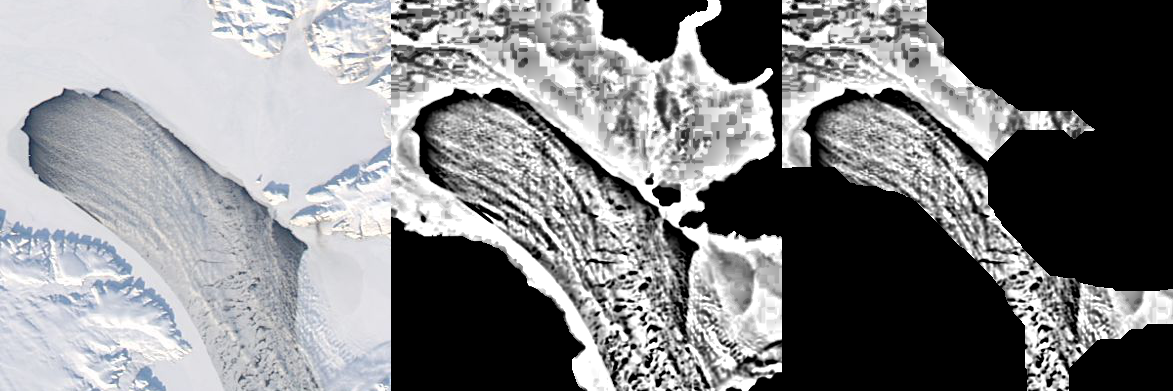

In [12]:
print("Left to right: true color image, sharpened image with orig. mask, sharpened gray image with dilated mask")
Images.mosaicview(
    truecolor_image, Gray.(sharpened_truecolor_image), Gray.(sharpened_gray_truecolor_image), nrow=1)

## Image normalization and ice/water discrimination

Left to right: normalized image, ice-water discrimination

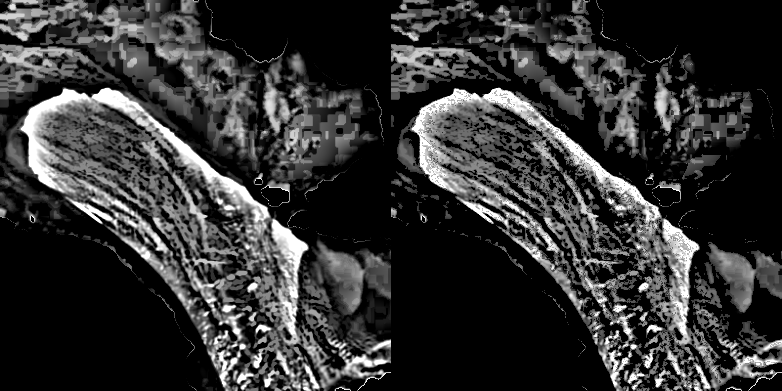

In [13]:
normalized_image = IceFloeTracker.normalize_image(
        sharpened_truecolor_image, sharpened_gray_truecolor_image, landmask_imgs.non_dilated
    )
ice_water_discrim = IceFloeTracker.discriminate_ice_water(
    falsecolor_image, normalized_image, copy(landmask_imgs.non_dilated), cloudmask
)
print("Left to right: normalized image, ice-water discrimination")
Images.mosaicview(normalized_image, ice_water_discrim, nrow=1)

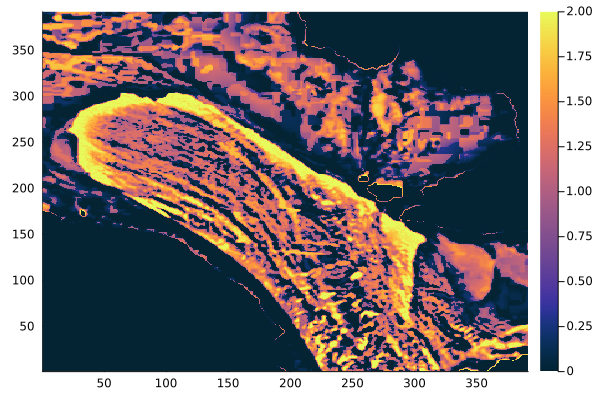

In [14]:
using Plots
Plots.heatmap(Float32.(normalized_image)[end:-1:1,:] +
    Float32.(ice_water_discrim)[end:-1:1,:].^0.25, c = :thermal)

The docstrings are very, very short in most cases and don't give enough information to let the user know how to use the function in isolation. 

In [531]:
?IceFloeTracker.discriminate_ice_water

```
discriminate_ice_water(
falsecolor_image::Matrix{RGB{Float64}},
normalized_image::Matrix{Gray{Float64}},
landmask_bitmatrix::T,
cloudmask_bitmatrix::T,
floes_threshold::Float64=Float64(100 / 255),
mask_clouds_lower::Float64=Float64(17 / 255),
mask_clouds_upper::Float64=Float64(30 / 255),
kurt_thresh_lower::Real=2,
kurt_thresh_upper::Real=8,
skew_thresh::Real=4,
st_dev_thresh_lower::Float64=Float64(84 / 255),
st_dev_thresh_upper::Float64=Float64(98.9 / 255),
clouds_ratio_threshold::Float64=0.02,
differ_threshold::Float64=0.6,
nbins::Real=155
```

)

Generates an image with ice floes apparent after filtering and combining previously processed versions of falsecolor and truecolor images from the same region of interest. Returns an image ready for segmentation to isolate floes.

Note: This function mutates the landmask object to avoid unnecessary memory allocation. If you need the original landmask, make a copy before passing it to this function. Example: `discriminate_ice_water(falsecolor_image, normalized_image, copy(landmask_bitmatrix), cloudmask_bitmatrix)`

# Arguments

  * `falsecolor_image`: input image in false color reflectance
  * `normalized_image`: normalized version of true color image
  * `landmask_bitmatrix`: landmask for region of interest
  * `cloudmask_bitmatrix`: cloudmask for region of interest
  * `floes_threshold`: heuristic applied to original false color image
  * `mask_clouds_lower`: lower heuristic applied to mask out clouds
  * `mask_clouds_upper`: upper heuristic applied to mask out clouds
  * `kurt_thresh_lower`: lower heuristic used to set pixel value threshold based on kurtosis in histogram
  * `kurt_thresh_upper`: upper heuristic used to set pixel value threshold based on kurtosis in histogram
  * `skew_thresh`: heuristic used to set pixel value threshold based on skewness in histogram
  * `st_dev_thresh_lower`: lower heuristic used to set pixel value threshold based on standard deviation in histogram
  * `st_dev_thresh_upper`: upper heuristic used to set pixel value threshold based on standard deviation in histogram
  * `clouds2_threshold`: heuristic used to set pixel value threshold based on ratio of clouds
  * `differ_threshold`: heuristic used to calculate proportional intensity in histogram
  * `nbins`: number of bins during histogram build


In [13]:
# 3. Segmentation
@info "Segmenting floes part 1/3"
ice_labels = IceFloeTracker.find_ice_labels(
        falsecolor_image, landmask_imgs.non_dilated
    );
segA = IceFloeTracker.segmentation_A(
    IceFloeTracker.segmented_ice_cloudmasking(ice_water_discrim, cloudmask, ice_labels)
);

[ Info: Segmenting floes part 1/3
[ Info: Done with reshape
[ Info: Done filling segmented_ice


In [14]:
segB = IceFloeTracker.segmentation_B(sharpened_gray_truecolor_image, cloudmask, segA);

In [15]:
print("Top, left to right: falsecolor image, segmentation B ice intersect\n")
print("Bottom, left to right: segmentation A, segmentation B not_ice_bit")
Images.mosaicview(falsecolor_image, Gray.(segA), Gray.(segB.ice_intersect),
     Gray.(segB.not_ice_bit), nrow=2)

Top, left to right: falsecolor image, segmentation B ice intersect
Bottom, left to right: segmentation A, segmentation B not_ice_bit

LoadError: UndefVarError: `segA` not defined

In [16]:
watersheds_segB = Folds.map(
        IceFloeTracker.watershed_ice_floes, [segB.not_ice_bit, segB.ice_intersect]
    );
watersheds_segB[1] .= IceFloeTracker.watershed_product(watersheds_segB...);

LoadError: UndefVarError: `segB` not defined

In [17]:
print("Left: Watershed result, Right: watershed product")
Images.mosaicview(Gray.(watersheds_segB[1]), Gray.(watersheds_segB[2]), nrow=1)

Left: Watershed result, Right: watershed product

LoadError: UndefVarError: `watersheds_segB` not defined

In [18]:
final_segmentation = IceFloeTracker.segmentation_F(
        segB.not_ice,
        segB.ice_intersect,
        watersheds_segB[1],
        ice_labels,
        cloudmask,
        landmask_imgs.dilated,
    );

[ Info: Done with reshape
[ Info: Done with k-means segmentation


In [18]:
print("Left: truecolor image. Right: Overlaid segmentation result")
Images.mosaicview(falsecolor_image, sharpened_gray_truecolor_image, falsecolor_image + Gray.(final_segmentation), nrow=1)


Left: truecolor image. Right: Overlaid segmentation result

LoadError: UndefVarError: `final_segmentation` not defined

In [21]:
Images.entropy(sharpened_gray_truecolor_image)

5.679958708705917